# Triangulate Each Cluster

In [1]:
import gc
import os
import pickle
import sys
import time
import uuid
from typing import Final, Optional

import cv2 as OpenCV
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.cluster.vq import kmeans, vq
from scipy.spatial import Delaunay
import cv2
from scipy.optimize import least_squares

In [2]:
class Image:
    def __init__(self, img_id, rgb_image, gray_image, mask, keypoints, descriptors, path):
        self.img_id: int = int(img_id)
        self.unique_id: uuid = uuid.uuid4()
        self.rgb_image: Image = rgb_image
        self.gray_image: Image = gray_image
        self.mask: Image = mask
        self.keypoints: list[OpenCV.KeyPoint] = keypoints
        self.descriptors: np.ndarray = descriptors
        self.path: str = path

    @property
    def length(self):
        return f"{len(self.keypoints)}" if len(self.keypoints) == len(self.descriptors) else f"{len(self.keypoints)}, {len(self.descriptors)}"
    
    def draw_sift_features(self):
        image_with_sift = OpenCV.drawKeypoints(self.rgb_image, self.keypoints, None, flags=OpenCV.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(image_with_sift)
        plt.title("Image with SIFT Features")
        plt.axis('off')
        plt.show()

    def display_rgb_image(self, title: Optional[str] = None):
        image = self.rgb_image
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axis('off')
        plt.show()

    def display_gray_image(self, title: Optional[str] = None):
        image = self.gray_image
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axes('off')
        plt.show()
        
    def display_mask_image(self, title: Optional[str] = None):
        image = self.mask
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axes('off')
        plt.show()
        
    def display_dialated_image(self, title: Optional[str] = None):
        print(self.mask.shape)
        print(self.rgb_image.shape)
        image = OpenCV.bitwise_and(self.rgb_image, self.rgb_image, mask=self.mask)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axis('off')
        plt.show()
        
    def __repr__(self):
        return f"Image({self.img_id})"
    
    def __str__(self):
        return self.__repr__()
    
    def __eq__(self, other):
        return self.unique_id == other.unique_id
    
    def __hash__(self):
        return hash(self.img_id)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        state['keypoints'] = [tuple(k.pt) + (k.size, k.angle, k.response, k.octave, k.class_id) for k in self.keypoints]
        return state
    
    def __setstate__(self, state):
        state['keypoints'] = [OpenCV.KeyPoint(x, y, size, angle, response, octave, class_id) for x, y, size, angle, response, octave, class_id in state['keypoints']]
        self.__dict__ = state

class FeatureMatches:
    def __init__(self, image_one: Image, image_two: Image, matches: list[OpenCV.DMatch]):
        self.image_one: Image = image_one
        self.image_two: Image = image_two
        self.matches: list[OpenCV.DMatch] = matches

    def draw_matches(self, output_filename: str) -> None:
        combined_image = OpenCV.hconcat([
            self.image_one.rgb_image,
            self.image_two.rgb_image
        ])

        for match in self.matches:
            x1, y1 = self.image_one.keypoints[match.queryIdx].pt
            x2, y2 = self.image_two.keypoints[match.trainIdx].pt
            # Draw a line connecting the matched keypoints
            OpenCV.line(
                combined_image, 
                (int(x1), int(y1)), 
                (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
                (0, 255, 0), 
                1
            )

        OpenCV.imwrite(output_filename, combined_image)
        
    def simulate_matches(self, output_dir: str) -> None:
        combined_image = OpenCV.hconcat([
            self.image_one.rgb_image,
            self.image_two.rgb_image
        ])

        for i, match in enumerate(self.matches):
            x1, y1 = self.image_one.keypoints[match.queryIdx].pt
            x2, y2 = self.image_two.keypoints[match.trainIdx].pt
            # Draw a line connecting the matched keypoints
            OpenCV.line(
                combined_image, 
                (int(x1), int(y1)), 
                (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
                (0, 255, 0), 
                1
            )
            if i % 5 == 0:
                resized_image = OpenCV.resize(combined_image, None, fx=0.5, fy=0.5, interpolation=OpenCV.INTER_AREA)
                OpenCV.imwrite(f"{output_dir}/{i}.jpg", resized_image)

    def __repr__(self):
        return f"FeatureMatches({self.image_one}, {self.image_two} ---> {len(self.matches)})"

    def __getstate__(self):
        state = self.__dict__.copy()
        state['matches'] = [
            {'queryIdx': m.queryIdx, 'trainIdx': m.trainIdx, 'distance': m.distance} for m in self.matches
        ]
        return state
    
    def __setstate__(self, state):
        state['matches'] = [
            OpenCV.DMatch(match['queryIdx'], match['trainIdx'], match['distance']) for match in state['matches']
        ]
        self.__dict__ = state
    
class Images:
    def __init__(self, images: list[Image], image_set_name: str):
        self.id = uuid.uuid4()
        self.images: list[Image] = images
        self.image_set_name: str = image_set_name
        self.feature_matches: list[FeatureMatches] = []
        self.similar_images: dict[list[Image]] = {}
        self.num_clusters: int = 50

    def save_feature_matches(self):
        for match in self.feature_matches:
            match.draw_matches(f"data/{self.image_set_name}/output/feature-match/{match.image_one.img_id}_{match.image_two.img_id}.jpg")

    def __len__(self):
        return len(self.images)
    
    def display_similar_images(self, key):
        print(f"cluster {key}")
        print("-----------------------------------------------------")
        for value in self.similar_images[key]:
            print(value)
            rgb_image = OpenCV.cvtColor(OpenCV.imread(value.path), OpenCV.COLOR_BGR2RGB)
            plt.imshow(rgb_image)
            plt.title(value.path)
            plt.axis('off')
            plt.show()

    def save_similar_images(self):
        for cluster in self.similar_images.keys():
            if not os.path.exists(f"data/{self.image_set_name}/output/image-match/{cluster}"):
                os.makedirs(f"data/{self.image_set_name}/output/image-match/{cluster}")
            for value in self.similar_images[cluster]:
                OpenCV.imwrite(f"data/{self.image_set_name}/output/image-match/{cluster}/{value.img_id}.jpg", value.rgb_image)

    def __getitem__(self, key: int) -> Image:
        for image in self.images:
            if image.img_id == key:
                return image
        raise KeyError(f'Image with img_id {key} not found.')

In [3]:
def feature_matching(
        img_one_descriptors: np.ndarray, 
        img_two_descriptors: np.ndarray,
    ) -> list[OpenCV.DMatch]:
    matcher = OpenCV.BFMatcher(crossCheck=True)
    return matcher.match(img_one_descriptors, img_two_descriptors)


def apply_ransac(matches, keypoints1, keypoints2, threshold = 3.0):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    _, mask = OpenCV.findHomography(src_pts, dst_pts, OpenCV.RANSAC, threshold)
    matches_mask = mask.ravel().tolist()
    return [m for m, keep in zip(matches, matches_mask) if keep]


def data_feature_matching(images: Images) -> None:
    import itertools
    for _, values in images.similar_images.items():
        print(images.similar_images.items())
        for image, matched_image in itertools.combinations(values, 2):
            feature_matching_output = feature_matching(image.descriptors, matched_image.descriptors)
            ransac_output = apply_ransac(feature_matching_output, image.keypoints, matched_image.keypoints, threshold=150)
            images.feature_matches.append(FeatureMatches(image, matched_image, ransac_output))

In [4]:
# import numpy as np
# import cv2 as OpenCV
# from typing import List, Tuple

# def check_coherent_rotation(R: np.ndarray) -> bool:
#     epsilon = 1e-6
#     return np.abs(np.linalg.det(R) - 1.0) <= epsilon


# def find_camera_matrices(K: np.ndarray, keypoints_one: np.ndarray, keypoints_two: np.ndarray, matches: List) -> Tuple[np.ndarray, np.ndarray]:
#     # Get Fundamental Matrix
#     F, _ = OpenCV.findFundamentalMat(keypoints_one, keypoints_two, method=OpenCV.FM_RANSAC, ransacReprojThreshold=3)

#     # Compute Essential matrix
#     E = K.T @ F @ K

#     # Decompose Essential matrix using SVD
#     _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K)

#     # Check if the resulting rotation is coherent
#     if not check_coherent_rotation(R):
#         print("Resulting rotation is not coherent")
#         return None, None
#     print("Resulting rotation is coherent")

#     return np.hstack((R, t))


# def generate_point_cloud(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
#     point_cloud = []

#     for feature_match in images.feature_matches:
#         image_one = feature_match.image_one
#         image_two = feature_match.image_two

#         # Extract matched keypoints
#         keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
#         keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])

#         # Find Camera Matrices
#         P1 = find_camera_matrices(K_matrix, keypoints_one, keypoints_two, feature_match.matches)
#         if P1 is None:
#             continue

#         # Create projection matrices
#         P0 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
#         P1 = K_matrix @ P1

#         # Triangulate points
#         points_4D = OpenCV.triangulatePoints(P0, P1, keypoints_one.T, keypoints_two.T)
#         points_3D = (points_4D / points_4D[3])[:3]

#         point_cloud.append(points_3D)

#     return np.hstack(point_cloud).T

In [5]:
# def generate_point_cloud(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
#     def remove_outliers(points_3D: np.ndarray, threshold: float = 100.0) -> np.ndarray:
#         # Calculate the mean and standard deviation of the 3D points
#         mean = points_3D.mean(axis=0)
#         std_dev = points_3D.std(axis=0)

#         # Remove points that are farther than the threshold * standard deviation from the mean
#         inliers = np.all(np.abs(points_3D - mean) < threshold * std_dev, axis=1)

#         return points_3D[inliers]

#     point_cloud = []
#     print("Feature Matches No. of Pairs: ", len(images.feature_matches))
#     for i, feature_match in enumerate(images.feature_matches):
#         image_one = feature_match.image_one
#         image_two = feature_match.image_two

#         # Extract matched keypoints
#         keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
#         keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])

#         # Estimate the essential matrix
#         E, mask = OpenCV.findEssentialMat(keypoints_one, keypoints_two, K_matrix, method=OpenCV.RANSAC, prob=0.999, threshold=1.0)
#         _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K_matrix)

#         print(f"R of Pair {i}: ", R)
#         print(f"t of Pair {i}: ", t)
#         print(f"Essential Matrix of Pair {i}: ", E)
#         print("Keypoint_1 Shape: ", keypoints_one.shape)
#         print("Keypoint_2 Shape: ", keypoints_two.shape)
#         print("\n")
#         # Create projection matrices
#         P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1)))) #P1 Shape: (3, 4)
#         P2 = K_matrix @ np.hstack((R, t)) #P2 Shape: (3, 4)

#         # Triangulate points
#         points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
#         points_3D = (points_4D / points_4D[3])[:3].T

#         # Remove outliers in the triangulated points
#         points_3D = remove_outliers(points_3D)

#         point_cloud.append(points_3D)

#     # Merge all point clouds into one
#     point_cloud = np.vstack(point_cloud)

#     return point_cloud

In [6]:
def generate_point_cloud(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
    point_cloud = []

    for feature_match in images.feature_matches:
        image_one = feature_match.image_one
        image_two = feature_match.image_two

        # Extract matched keypoints
        keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
        keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])

        # Normalize keypoints using the K matrix
        # keypoints_one_normalized = np.linalg.inv(K_matrix) @ np.vstack((keypoints_one.T, np.ones(keypoints_one.shape[0])))
        # keypoints_two_normalized = np.linalg.inv(K_matrix) @ np.vstack((keypoints_two.T, np.ones(keypoints_two.shape[0])))

        # Estimate the Fundamental matrix using the 8-point algorithm
        # F, _ = OpenCV.findFundamentalMat(keypoints_one_normalized[:2].T, keypoints_two_normalized[:2].T, method=OpenCV.FM_8POINT)
        F, _ = OpenCV.findFundamentalMat(keypoints_one, keypoints_two)

        # Estimate the Essential matrix
        E = K_matrix.T @ F @ K_matrix

        # Decompose the Essential matrix to get R|t using SVD
        _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K_matrix)

        # Create projection matrices
        P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = K_matrix @ np.hstack((R, t))

        # Triangulate points
        points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
        points_3D = (points_4D / points_4D[3])[:3]

        point_cloud.append(points_3D)

    return np.hstack(point_cloud).T

In [7]:
def dump_images_bak(images_file_path: str, images: Images) -> None:
    """ Dump images to a file """
    with open(images_file_path, "wb") as file:
        pickle.dump(images, file)

def load_images_bak(images_file_path: str) -> Images:
    """ Load images from a file """
    with open(images_file_path, "rb") as file:
        images = pickle.load(file)
    return images

In [8]:
images: Images = load_images_bak("data/cottage/bak/images-matched.pkl")

In [9]:
print(images.similar_images.items())

dict_items([(2, [Image(8), Image(9), Image(10), Image(23), Image(26), Image(24), Image(25), Image(7)]), (1, [Image(14), Image(15), Image(17), Image(16), Image(20), Image(18), Image(30), Image(19), Image(2), Image(3), Image(1)]), (0, [Image(28), Image(29), Image(12), Image(13), Image(11), Image(21), Image(22), Image(27), Image(4), Image(5), Image(6)])])


In [10]:
images.similar_images = {
    "0": [images[10], images[11]]
    # "1": [images[11], images[12], images[13], images[14], images[15], images[16], images[17], images[18], images[19], images[20], images[21], 
    #     images[22], images[23], images[24], images[25], images[26], images[27]]
}

In [11]:
print(images.similar_images.items())

dict_items([('0', [Image(10), Image(11)])])


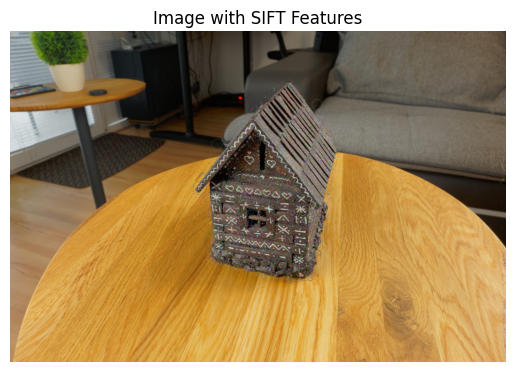

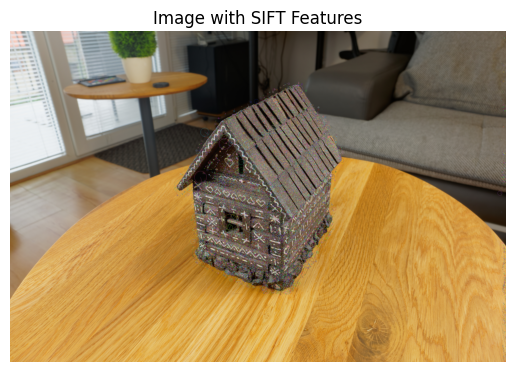

In [12]:
images[10].draw_sift_features()
images[11].draw_sift_features()

In [13]:
data_feature_matching(images)

dict_items([('0', [Image(10), Image(11)])])


In [ ]:
images.feature_matches

In [ ]:
print(images.feature_matches[0])   

In [ ]:
images.feature_matches[0].draw_matches("data/cottage/output/triangulate/10_11.jpg")

In [ ]:
with open("data/cottage/bak/K_matrix.pickle", 'rb') as f:
        K_matrix = pickle.load(f)

In [ ]:
print(K_matrix)

# Clustering from: 10 and 11

In [ ]:
data_10_11_points_cloud: np.ndarray = generate_point_cloud(images, K_matrix)

In [ ]:
import hdbscan
hdbscan_model = hdbscan.HDBSCAN().fit(data_10_11_points_cloud)
labels = hdbscan_model.labels_
core_indices = np.where(labels != -1)[0]
core_points_10_11_HDBSCAN = data_10_11_points_cloud[core_indices, :]

In [ ]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=10).fit(one_11_points_cloud)
# labels = dbscan.labels_
# core_indices = np.where(labels != -1)[0]
# core_points_1_11_DBSCAN = one_11_points_cloud[core_indices, :]

In [ ]:
print(data_10_11_points_cloud.shape)
print(core_points_10_11_HDBSCAN.shape)

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data_10_11_points_cloud[:,:3])
o3d.io.write_point_cloud(
    "data/cottage/output/triangulate/data_10_11_points_cloud.ply", pcd
)

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(core_points_10_11_HDBSCAN[:,:3])
o3d.io.write_point_cloud(
    "data/cottage/output/triangulate/core_points_10_11_HDBSCAN.ply", pcd
)

# Visualizing Points Cloud

In [ ]:
import open3d as o3d
file_path = (
    "data/cottage/output/triangulate/core_points_10_11_HDBSCAN.ply"
)
point_cloud = o3d.io.read_point_cloud(file_path)
o3d.visualization.draw_geometries([point_cloud])